### Introduction

We have deployed our model and it is successfully being used to determine the class of Iris flowers by botanists all over the world!

Enjoying our success and the data science we have been doing, has resulted in us spending more time learning more about LinearSVC models.

One thing we noticed in the [LinearSVC documentation](https://scikit-learn.org/stable/modules/svm.html#svm-classification) was the following:

> Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data.

Oh. What does 'scale your data' mean?


### Scaling Data

There are many ways to scale data (see the [Appendix](#Appendix)).  A good starting point for learning about scalers is StandardScaler:

> Standardize features by removing the mean and scaling to unit variance.
>
> *Source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html*

We will try the StandardScaler, below:


In [1]:
# ensure everyone running this code gets the same result
import numpy as np
np.random.seed(100)

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# We 'fit' the StandardScaler on the training data
std_slc = StandardScaler()
std_slc.fit(X_train)

# We can then use the scaler to transform out training and test datasets
X_train_std = std_slc.transform(X_train)
X_test_std = std_slc.transform(X_test)

Next we can print out the datasets.  We wrap the datasets with pandas dataframes to give us easier to read tables.

In [2]:
import pandas as pd
X_train_df = pd.DataFrame(X_train, columns=["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"])
X_train_std_df = pd.DataFrame(X_train_std, columns=["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"])

Let's look at the first few records of the unscaled and the scaled dataset

In [3]:
display(X_train_df.head())
display(X_train_std_df.head())

,Sepal Length,Sepal Width,Petal Length,Petal Width
0,5.1,3.3,1.7,0.5
1,5.0,3.2,1.2,0.2
2,6.5,2.8,4.6,1.5
3,7.9,3.8,6.4,2.0
4,6.1,3.0,4.9,1.8


,Sepal Length,Sepal Width,Petal Length,Petal Width
0,-0.916069,0.595736,-1.251745,-0.998077
1,-1.040535,0.356485,-1.546968,-1.413942
2,0.826454,-0.600521,0.460548,0.388141
3,2.568977,1.791994,1.523351,1.081250
4,0.328590,-0.122018,0.637682,0.804006


We won't describe in detail the scaling process because that is covered in the StandardScaler documentation.

However, let's revist the description of the StandardScaler:

> Standardize features by removing the mean and scaling to unit variance


We can print out the mean and variance as follows (note that we are looking at Sepal Width):

In [4]:
print("---")
print("Unscaled Mean:     " + str(X_train_df['Sepal Width'].mean()))
print("Scaled Mean:       " + str(X_train_std_df['Sepal Width'].mean()))
print("")
print("Unscaled Variance: " + str(X_train_df['Sepal Width'].var()))
print("Scaled Variance:   " + str(X_train_std_df['Sepal Width'].var()))
print("---")

---
Unscaled Mean:     3.0509999999999993
Scaled Mean:       6.483702463810914e-16

Unscaled Variance: 0.17646363636363638
Scaled Variance:   1.0101010101010097
---


You can see that the scaled mean is approximately zero and the variance is approximately one.

This can be viewed graphically:

<AxesSubplot:ylabel='Frequency'>

<AxesSubplot:ylabel='Frequency'>

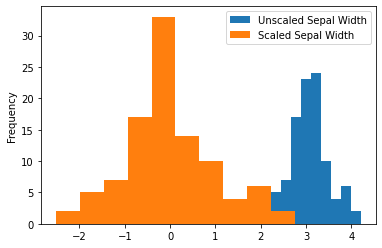

In [5]:
display(X_train_df['Sepal Width'].rename("Unscaled Sepal Width").plot.hist(legend=True))
display(X_train_std_df['Sepal Width'].rename("Scaled Sepal Width").plot.hist(legend=True))

**Exercise 12.01:**
    
Explore the mean and variance for the other features.

### Anti-pattern: Inconsistent Preprocessing


>  If ... data transforms are used when training a model, they also must be used on subsequent datasets, whether it’s test data or data in a production system. Otherwise, the feature space will change, and the model will not be able to perform effectively.
>
> https://scikit-learn.org/stable/common_pitfalls.html#inconsistent-preprocessing

To summarise the above; if we transform our training data then we must also transform the test data and the data being used to make inferences in production.

To understand why this is important, let's create a new Iris classifier, but this time using a [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/tree.html#tree-classification).  Note that we are NOT scaling the training data.



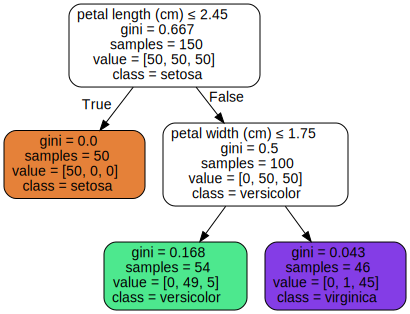

In [6]:
# ensure everyone running this code gets the same result
import numpy as np
np.random.seed(100)

# train the decision tree classifier
from sklearn.datasets import load_iris
from sklearn import tree
iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X, y)

# display the decision tree
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=iris.feature_names,  
                     class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

Here we have made a decision tree with a depth of two `clf = tree.DecisionTreeClassifier(max_depth=2)`.  

If we read from the top, we can see that if the `Petal length <= 2.45` the predicted class is `Setosa`.

However, when we standardized the training data we 'shifted' the values. See the [box plots](https://en.wikipedia.org/wiki/Box_plot), below, comparing the Unscaled Petal Length values to the Scaled Petal Length values.

Text(0.5, 1.0, 'Unscaled')

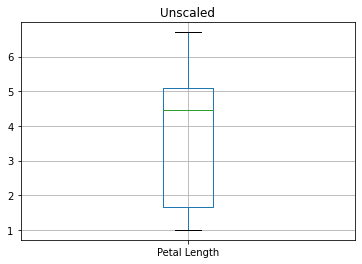

In [7]:
X_train_df.boxplot(column='Petal Length').axes.set_title('Unscaled')

Text(0.5, 1.0, 'Scaled')

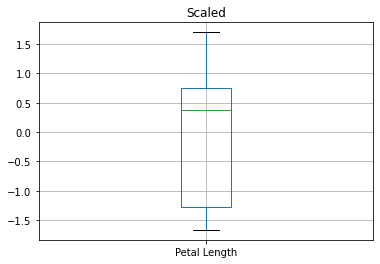

In [8]:
X_train_std_df.boxplot(column='Petal Length').axes.set_title('Scaled')

Note that the scaled training data has been shifted compared to the unscaled data.

So if we don't 'shift' the prediction data, the decision tree rules will be invalid.

The first rule in the decision tree, based on unscaled data is `Petal length <= 2.45`.  However, the scaled Petal length values from the training data (as per the box chart) is approximately `-1.75` to `+1.75` **so no records would trigger the first rule**.


**Exercise 12.02**

Experiment with the depth parameter on the DecisionTreeClassifier. 

Generally increasing the depth will create a more accurate model, but risks '[Overfitting](https://en.wikipedia.org/wiki/Overfitting)' the model to the training data.

### Scaled Inference Example

In this example, we create a scaler for the training data

In [13]:
# set the random state to make the examples repeatable
import numpy as np
np.random.seed(1)

from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# We 'fit' the StandardScaler on the training data
std_slc = StandardScaler()
std_slc.fit(X_train)

X_train_std = std_slc.transform(X_train)
X_test_std = std_slc.transform(X_test)

classifier = LinearSVC()
model = classifier.fit(X_train_std, y_train)

# Testing the model is left as an exercise for the reader

from joblib import dump
dump(model, 'iris_model_scaled.joblib')
dump(std_slc, 'iris_data_scaler.joblib')

['iris_data_scaler.joblib']

Now let's make a prediction using the same feature data we used to make a prediction using an unscaled model in the [Previous](./11_model_predictions.ipynb) notebook.

In [16]:
# set the random state to make the examples repeatable
import numpy as np
np.random.seed(1)

from joblib import load

scaler_file = load('iris_data_scaler.joblib') 
model_file = load('iris_model_scaled.joblib') 

new_sepal_length = 5.9
new_sepal_width = 3.0
new_petal_length = 5.1
new_petal_width = 1.8

# Scale the input features
X_new = scaler_file.transform([ 
    [ new_sepal_length, new_sepal_width, new_petal_length, new_petal_width ] 
])
print("Scaled input features: " + str(X_new))

prediction = model_file.predict(X_new)
print("Predicted class: " + str(prediction))

Scaled input features: [[ 0.11352823 -0.07994018  0.75731121  0.76873449]]
Predicted class: [2]


**Excercise 12.03**

Compare the results of the scaled model prediction to the unscaled model prediction in the [Previous](./11_model_predictions.ipynb) notebook.  The result should be the same.

**Excercise 12.04**

Read through the documentation and try the examples on:
    
- [Preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html)
- [Imputation of missing values](https://scikit-learn.org/stable/modules/impute.html)
- [Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
- [Feature Extrac

---
### Navigation

[Previous](./11_model_predictions.ipynb) | [Home](./00-README-FIRST.ipynb) | [Next](./98_outro.ipynb) notebook

---

<div class="alert-info">

### Appendix

Other Scikit-learn scalers:

- [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
- [sklearn.preprocessing.MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
- [sklearn.preprocessing.RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)
- [sklearn.preprocessing.Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html)
- [sklearn.preprocessing.QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html)
- [sklearn.preprocessing.PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)

</div>

**Solution for Exercise 12.01**

There are a few solutions, here we augment the [describe method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) with a variance statistic:

In [11]:
summary_stats = X_train_df.describe()

# add 'variance' because describe doesn't show it
summary_stats.loc['variance'] = summary_stats.loc['std']**2
summary_stats

,Sepal Length,Sepal Width,Petal Length,Petal Width
count,100.000000,100.000000,100.000000,100.000000
mean,5.836000,3.051000,3.820000,1.220000
std,0.807480,0.420076,1.702167,0.725022
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.675000,0.300000
50%,5.800000,3.000000,4.450000,1.400000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.200000,6.700000,2.500000
variance,0.652024,0.176464,2.897374,0.525657


In [12]:
summary_stats = X_train_std_df.describe()
summary_stats.loc['variance'] = summary_stats.loc['std']**2
summary_stats

,Sepal Length,Sepal Width,Petal Length,Petal Width
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,7.149836e-16,6.483702e-16,8.770762e-16,-2.664535e-16
std,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00
min,-1.911797e+00,-2.514534e+00,-1.665058e+00,-1.552564e+00
25%,-9.160693e-01,-6.005214e-01,-1.266507e+00,-1.275320e+00
50%,-4.480774e-02,-1.220183e-01,3.719809e-01,2.495191e-01
75%,7.019879e-01,5.957364e-01,7.557708e-01,8.040061e-01
max,2.568977e+00,2.749001e+00,1.700484e+00,1.774358e+00
variance,1.010101e+00,1.010101e+00,1.010101e+00,1.010101e+00


**Solution for Exercise 12.02**

No solution required - just experiment and observe :)